In [25]:
import sys
import os

sys.path.append(os.path.join(os.getcwd(), '../'))
from Q_convert import *

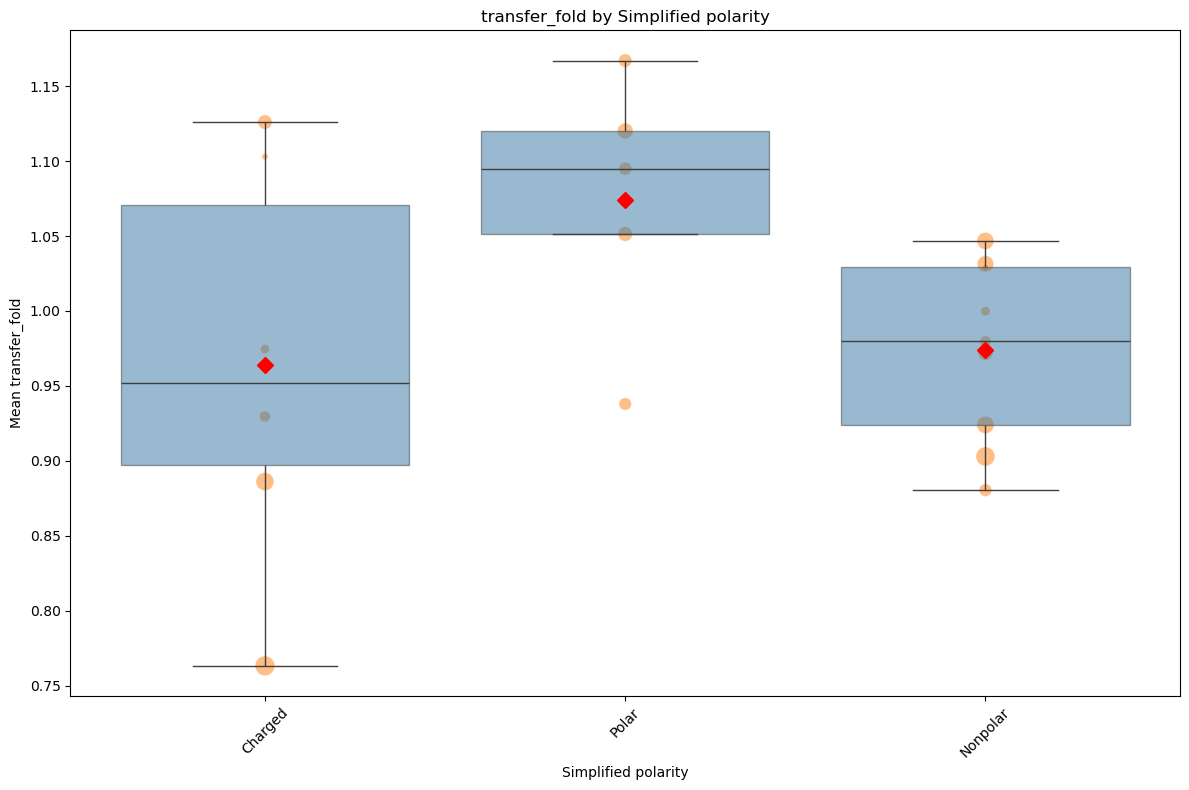

Regression Line: y = -0.03x + 0.99
Correlation Coefficient: R² = 0.04


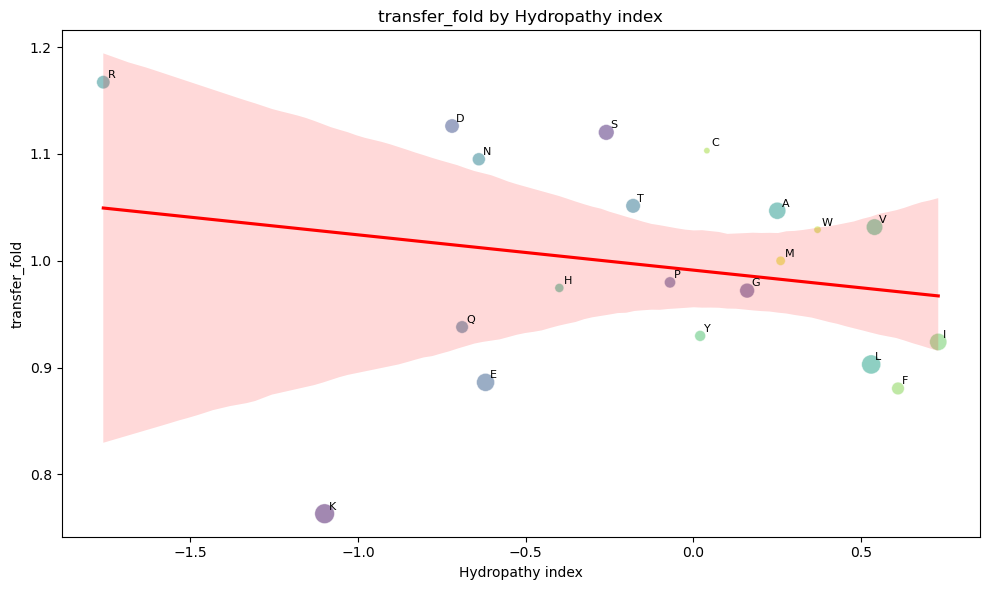

Regression Line: y = 0.05x + 0.96
Correlation Coefficient: R² = 0.09


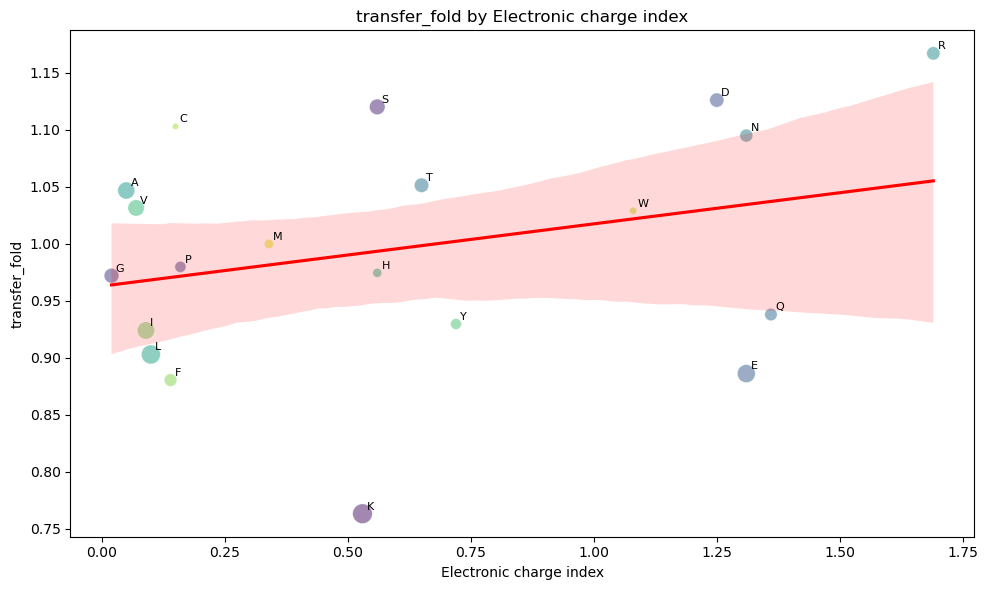

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress


# Load the CSV file into a DataFrame
file_path = '/home/tim/project/bacterialQ/data/others/aa_property.csv'
aa_properties = pd.read_csv(file_path)

all_model_nex = "/home/tim/project/bacterialQ/data/modelset.nex"
trained_model_nex = "/home/tim/project/bacterialQ/analysis/phylumwise_compare/trained_models_all.nex"

# Extract reference and trained models
ref_model = extract_spc_Q_from_nex(all_model_nex, 'Q.PFAM')
trained_model = extract_spc_Q_from_nex(trained_model_nex, 'p__Patescibacteria_150_2')

# Create Q matrices for all models
ref_model.create_Q_matrix()
trained_model.create_Q_matrix()

# Define AA_ORDER
AA_ORDER = 'ARNDCQEGHILKMFPSTWYV'

# Extract diagonal elements and calculate transfer_fold
ref_diag = np.diag(ref_model.Q_matrix)
trained_diag = np.diag(trained_model.Q_matrix)
transfer_fold = trained_diag / ref_diag
state_freq = trained_model.state_freq

# Create a dictionary with the data
data = {
    'Amino acid': list(AA_ORDER),
    'transfer_fold': transfer_fold,
    'state_freq': state_freq
}

# Convert the dictionary to a pandas DataFrame
aa_model_info = pd.DataFrame(data)

aa_properties = pd.merge(aa_properties, aa_model_info, on='Amino acid', how='inner')


# Function to plot by categorical variable
def plot_categorical(df, category_name, response_col, size_col):
    # Group by the categorical variable and calculate the mean of response_col
    grouped_data = df.groupby(category_name)[response_col].mean().reset_index()
    
    # Merge the original dataframe with the grouped data to retain the size_col information
    merged_data = pd.merge(df, grouped_data, on=category_name, suffixes=('', '_mean'))
    
    # Sort the groups by the mean response_col
    sorted_data = grouped_data.sort_values(by=f'{response_col}')
    
    # Box plot with semi-transparent fill and edgecolor
    plt.figure(figsize=(12, 8))
    sns.boxplot(x=category_name, y=response_col, data=df, palette=None, linewidth=1, fliersize=0, boxprops=dict(alpha=0.5))
    
    # Point plot for means
    plt.plot(sorted_data[category_name], sorted_data[response_col], 'D', color='red', markersize=8)
    
    # Scatter plot on top of the box plot for individual points
    sns.scatterplot(x=merged_data[category_name], y=merged_data[response_col], size=merged_data[size_col], sizes=(20, 200), legend=False, alpha=0.5)
    
    # Plot titles and labels
    plt.title(f'{response_col} by {category_name}')
    plt.xlabel(category_name)
    plt.ylabel(f'Mean {response_col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
# Function to plot by numerical variable
def plot_numerical(df, variable_name, response_col, size_col):
    df[variable_name] = pd.to_numeric(df[variable_name], errors='coerce')
    
    # Scatter plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=df[variable_name], y=df[response_col], hue=df['Amino acid'], size=df[size_col], sizes=(20, 200), palette='viridis', legend=False, alpha=0.5)
    
    # Add annotations
    for i, txt in enumerate(df['Amino acid']):
        plt.annotate(txt, (df[variable_name].iloc[i], df[response_col].iloc[i]), fontsize=8, xytext=(3, 3), textcoords='offset points')
    
    # Add regression line
    sns.regplot(x=df[variable_name], y=df[response_col], scatter=False, color='red')
    
    # Calculate regression line equation and correlation coefficient
    slope, intercept, r_value, p_value, std_err = linregress(df[variable_name].dropna(), df[response_col].dropna())
    regression_eq = f'y = {slope:.2f}x + {intercept:.2f}'
    correlation_coefficient = f'R² = {r_value**2:.2f}'
    
    # Print regression line equation and correlation coefficient
    print(f'Regression Line: {regression_eq}')
    print(f'Correlation Coefficient: {correlation_coefficient}')
    
    # Plot titles and labels
    plt.title(f'{response_col} by {variable_name}')
    plt.xlabel(variable_name)
    plt.ylabel(response_col)
    plt.tight_layout()
    plt.show()
# Example usage
# plot_categorical('Chemical polarity')
plot_categorical(aa_properties, 'Simplified polarity', 'transfer_fold', 'state_freq')
plot_numerical(aa_properties, 'Hydropathy index', 'transfer_fold', 'state_freq')
plot_numerical(aa_properties, 'Electronic charge index', 'transfer_fold', 'state_freq')